In this notebook I will update the Dataloader and training routine to accumulate the gradients. This is done for two purposes, first the new PyTorch implementation seems to have increased memory consumption, so to make the code more portable controlling the batchsize can be very usefull. Then I will also like to test if increasing the msa size has a good effect on the training. This clearly increases the memory consumption, so I need again to control the memory consumption.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys


sys.path.insert(1, "./../util")
sys.path.insert(1, "./../model")
from encoded_protein_dataset_new import get_embedding, EncodedProteinDataset_new, collate_fn_new#, dynamic_collate_fn
from pseudolikelihood import get_npll2, get_npll_indep
import torch, torchvision
from torch.nn.utils import clip_grad_norm_
from potts_decoder import PottsDecoder
from torch.utils.data import DataLoader, RandomSampler
from functools import partial
import biotite.structure
from biotite.structure.io import pdbx, pdb
from biotite.structure.residues import get_residues
from biotite.structure import filter_backbone
from biotite.structure import get_chains
from biotite.sequence import ProteinSequence
from typing import Sequence, Tuple, List
import scipy
from tqdm import tqdm
import pandas as pd
import csv
import time
from torch.utils.tensorboard import SummaryWriter

#import pytorch_warmup as warmup
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR

##TURIN HPC
#sys.path.insert(1, "/Data/silva/esm/")

## EUROPA
#sys.path.insert(1, "/home/lucasilva/esm/")

##Lucas computer
sys.path.insert(1, "/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/esm/")
import esm
#from esm.inverse_folding import util
import esm.pretrained as pretrained
from ioutils import read_fasta, read_encodings
from torch.nn.utils.rnn import pad_sequence
from collections import defaultdict
from Bio import SeqIO



In [37]:
#for s in seq_records[0].seq:
    #if s.islower() or s=='.':
    #    print(s)
#    print(s)

In [4]:
file = "/home/luchinoprince/split2/train/12asA00_train.a3m"
msa = read_fasta(file)

In [5]:
msa[0].shape

torch.Size([208, 327])

In [6]:
pdbfile = "/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/structure_encodings/12asA00.encodings.pt" #/12asA00_train.a3m
encod = torch.load(pdbfile)

In [7]:
encod['encodings'].shape

torch.Size([327, 512])

In [49]:
encod['seq'][0:15]

'AYIAKQRQISFVKSH'

In [50]:
aux[3:18]

'AYIAKQRQISFVKSH'

In [18]:
file = "/home/luchinoprince/split/train/12asA00_train.a3m.pt"
msa = torch.load(file)

In [21]:
msa[1, 1:5]

tensor([20, 20, 20, 20])

In [15]:
file = "/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/msas/train/12asA00_train.a3m.pt"
msa= torch.load(file)

In [20]:
msa[1, 1:5]

tensor([20, 20, 20, 20])

In [2]:
from dynamic_loader import dynamic_collate_fn, dynamic_cluster

In [3]:
### IDEA: MSAS PROCEDURE CAN GIVE DIFFERENT OUTPUT SHAPES? ASK
max_msas = None
#msa_dir = "/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/msas/"
msa_dir = "/home/luchinoprince/split2/"
#encoding_dir ="/media/luchinoce/split2/"
encoding_dir ="/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/structure_encodings/"

train_dataset = EncodedProteinDataset_new(os.path.join(msa_dir, 'train'), encoding_dir, noise=0.02, max_msas=max_msas)          ## Default value of noise used
sequence_test_dataset = EncodedProteinDataset_new(os.path.join(msa_dir, 'test/sequence'), encoding_dir, noise=0.0, max_msas=max_msas)
structure_test_dataset = EncodedProteinDataset_new(os.path.join(msa_dir, 'test/structure'), encoding_dir, noise=0.0, max_msas=max_msas)
superfamily_test_dataset = EncodedProteinDataset_new(os.path.join(msa_dir, 'test/superfamily'), encoding_dir, noise=0.0, max_msas=max_msas)


/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/Inverse_Folding/train/./../util/encoded_protein_dataset_new.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encodings = torch.tensor(read_encodings(encoding_path, trim=False))


/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/structure_encodings/1vwxh02.encodings.pt Mismatch in dimension, skipping /home/luchinoprince/split2/train/1vwxh02_train.a3m.pt
/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/structure_encodings/3o58E00.encodings.pt Mismatch in dimension, skipping /home/luchinoprince/split2/train/3o58E00_train.a3m.pt
/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/structure_encodings/2wc7A01.encodings.pt Mismatch in dimension, skipping /home/luchinoprince/split2/train/2wc7A01_train.a3m.pt
/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/structure_encodings/1vwxP00.encodings.pt Mismatch in dimension, skipping /home/luchinoprince/split2/train/1vwxP00_train.a3m.pt
/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/structure_encodings/1vwxG01.encodings.pt Mismatch in dimension, skipping /home/luchinoprince/split2/tr

In [6]:
## 22468, 22428, 1374, 2673 old dataset, now a little fewer as we can see but comparable

In [4]:
print(f"I have loaded the train and test datasets: train:{len(train_dataset)}, seq:{len(sequence_test_dataset)}, struc:{len(structure_test_dataset)}, super:{len(superfamily_test_dataset)}")

I have loaded the train and test datasets: train:22463, seq:22396, struc:1364, super:2672


In [5]:
batch_structure_size_train = 32### I think with empty GPU we can go up to 16 easily
batch_structure_size=32
perc_subset_test = 1.0     ## During the training, for every dataset available we select a random 10% of its samples
batch_msa_size = 64 ### old is 32, original is 16
q = 21 ##isn't always 21
#dynamic_collate_fn

collate_fn = partial(dynamic_collate_fn, q=q, batch_size=batch_structure_size, batch_msa_size=batch_msa_size)
train_loader = DataLoader(train_dataset, batch_size=batch_structure_size_train, collate_fn=collate_fn, shuffle=True,
num_workers=1, pin_memory=True)


sequence_test_loader = DataLoader(sequence_test_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=False, 
num_workers=4, pin_memory=True, sampler=RandomSampler(sequence_test_dataset, replacement=True, num_samples=int(perc_subset_test*len(sequence_test_dataset))))

structure_test_loader = DataLoader(structure_test_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=False, 
num_workers=4, pin_memory=True, sampler=RandomSampler(structure_test_dataset, replacement=True, num_samples=int(perc_subset_test*len(structure_test_dataset))))

superfamily_test_loader = DataLoader(superfamily_test_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=False, 
num_workers=4, pin_memory=True, sampler=RandomSampler(superfamily_test_dataset, replacement=True, num_samples=int(perc_subset_test*len(superfamily_test_dataset))))

In [6]:
decoder = None
embedding = None
torch.cuda.empty_cache()

seed = 24877
torch.random.manual_seed(seed)
np.random.seed(seed)



update_steps = 210000                                      ##Usual values are update steps=10^5, test_steps=10^2
test_steps = 7000
bk_iter = False                                                  ## This tells us how ofter we save a model(default values is every ten-thousand updates)
#n_epochs = update_steps//(len(train_dataset)//batch_structure_size)   ## the other update steps will be used for "partial epochs", I want to save the last complet epoch
#print(f"With update_steps:{update_steps} we will do {n_epochs} full epochs")

input_encoding_dim = 512
param_embed_dim = 512
n_param_heads = 48
d_model = 512 ##old 512
n_heads = 8 ## old 8
n_layers = 6
## Check before running which is the GPU which is free the most and put it as the running device
device = 0        ## DON'T SET TO ONE OTHER THAN IN SPECIAL SPECIAL OCCASIONS, VERY NOISYYYYY!
dropout = 0.1

decoder = PottsDecoder(q, n_layers, d_model, input_encoding_dim, param_embed_dim, n_heads, n_param_heads, dropout=dropout)
decoder.to(device)
embedding = get_embedding(q)
embedding.to(device)

Embedding(22, 21)

In [7]:
def get_loss_new(decoder, inputs, eta_J, eta_h):
    """eta_J is the multiplicative term in front of the penalized negative pseudo-log-likelihood for the Couplings
        if no penalty is proveded for the fields, we put the equal to one another """
    msas, encodings, padding_mask  = [input.to(device, non_blocking=True) for input in inputs]
    B, M, N = msas.shape
    #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
    param_embeddings, fields = decoder.forward_new(encodings, padding_mask)
    msas_embedded = embedding(msas)
    #eta = eta_J
    # get npll
    npll = get_npll2(msas_embedded, param_embeddings, fields, N, q)
    padding_mask_inv = (~padding_mask)
    # multiply with the padding mask to filter non-existing residues (this is probably not necessary)       
    npll = npll * padding_mask_inv.unsqueeze(1)
    npll_mean = torch.sum(npll) / (M * torch.sum(padding_mask_inv))
    
    Q = torch.einsum('bkuia, buhia->bkhia', 
                param_embeddings.unsqueeze(2), param_embeddings.unsqueeze(1)).sum(axis=-1)
    #penalty = eta*(torch.sum(torch.sum(Q,axis=-1)**2) - torch.sum(Q**2) + torch.sum(fields**2))/B
    penalty = eta_J/B*(torch.sum(torch.sum(Q,axis=-1)**2) - torch.sum(Q**2)) + eta_h/B*torch.sum(fields**2) 
    loss_penalty = npll_mean + penalty
    return loss_penalty, npll_mean.item() 

def get_loss_indep(decoder, inputs, eta):
    """eta is the multiplicative term in front of the penalized negative pseudo-log-likelihood"""
    msas, encodings, padding_mask  = [input.to(device, non_blocking=True) for input in inputs]
    B, M, N = msas.shape
    #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
    fields = decoder.forward_indep(encodings, padding_mask)
    msas_embedded = embedding(msas)

    # get npll
    npll = get_npll_indep(msas_embedded, fields, N, q)
    padding_mask_inv = (~padding_mask)
    # multiply with the padding mask to filter non-existing residues (this is probably not necessary)       
    npll = npll * padding_mask_inv.unsqueeze(1)
    npll_mean = torch.sum(npll) / (M * torch.sum(padding_mask_inv))
    
    #Q = torch.einsum('bkuia, buhia->bkhia', 
    #            param_embeddings.unsqueeze(2), param_embeddings.unsqueeze(1)).sum(axis=-1)
    penalty = eta*(torch.sum(fields**2))/B
    loss_penalty = npll_mean + penalty
    return loss_penalty, npll_mean.item() 


def get_loss_loader(decoder, loader, eta_J, eta_h):
    decoder.eval()
    losses = []
    #with torch.no_grad():
    for effective_batch_size, inputs_packed in loader:
        npll_full = 0
        for inputs in inputs_packed:
            mini_batch_size = inputs[0].shape[0]
            #_, npll = get_loss_indep(decoder, inputs, eta_J, eta_h) ## For independent model without couplings
            _, npll = get_loss_new(decoder, inputs, eta_J, eta_h)
            npll_full += npll*mini_batch_size/effective_batch_size
        losses.append(npll_full)
            #del inputs
    
    return np.mean(losses)

def train(decoder, inputs_packed, eta_J, eta_h, optimizer, scaler):
    effective_batch_size = inputs_packed[0]
    loss_penalty_full = 0
    train_loss_full = 0
    optimizer.zero_grad(set_to_none=True)                           ## set previous gradients to 0
    with torch.cuda.amp.autocast():  ## autocasting mixed precision
        for inputs in inputs_packed[1]:
            mini_batch_size = inputs[0].shape[0]
            #loss_penalty, train_batch_loss = get_loss_indep(decoder, inputs, eta_J, eta_h)    ## get the current loss for the batch this is for the independent training
            loss_penalty, train_batch_loss = get_loss_new(decoder, inputs, eta_J, eta_h)
            loss_penalty = loss_penalty * mini_batch_size/effective_batch_size
            train_batch_loss = train_batch_loss * mini_batch_size/effective_batch_size
            #loss_penalty.backward()                         ## Get gradients
            scaler.scale(loss_penalty).backward()
            loss_penalty_full += loss_penalty.detach()
            train_loss_full += train_batch_loss
    
    
    scaler.step(optimizer)
    scaler.update()
    #optimizer.step()   

    return loss_penalty_full, train_loss_full

In [8]:
#summary_writer = SummaryWriter(log_dir='runs/indep_model')#log_dir=logdir)
summary_writer = SummaryWriter()
layout = {
    "metrics": {
        "loss": ["Multiline", ["loss/train", "loss/sequence", "loss/structure", "loss/superfamily"]],}
}
summary_writer.add_custom_scalars(layout)

## Let us also save the hyperparameters
#with summary_writer as w:
import warnings
warnings.filterwarnings("ignore")
lr = 1e-4#3.5e-4
optimizer = torch.optim.AdamW(decoder.parameters(), lr=lr)
eta_J = 1e-4#2.15e-6
eta_h = 1e-4#6.51e-4


hyperparams = {'lr':lr, 'eta_J':eta_J, 'eta_h':eta_h, 'batch_size':batch_structure_size, 'batch_msa_size':batch_msa_size, 'n_param_heads':n_param_heads, 'n_layers':n_layers, 
                'dropout':dropout, 'param_embed_dim':param_embed_dim, 'n_heads': n_heads}

start = time.time()
scaler = torch.cuda.amp.GradScaler()
with tqdm(total = update_steps) as pbar: ##This is used to have the nice loading bar while training
    train_loss = 0
    update_step = 0
    max_gpu=0
    train_batch_losses = []
    epoch = 0.0
    while update_step < update_steps:
        for inputs_packed in train_loader:
            decoder.train()

            loss_penalty, train_batch_loss = train(decoder, inputs_packed, eta_J, eta_h, optimizer, scaler)
            loss_penalty.detach()
            #optimizer.step()                                ## Do a step of GD
            update_step += 1                                ## Increase update step (the update steps will count also different batches within the same epoch)
            epoch = update_step / len(train_loader)
            
            train_batch_losses.append(train_batch_loss) ## Here we append the lossess in the different batches within the same epoch
            
            ## We want to keep track of the test loss not at every batch, too costrly otherwise. Usually set to once every 100.
            if (update_step  == 1) or (epoch % 5 == 0):
                #check_aux = train_batch_losses.copy()
                #print(check_aux)
                train_loss = np.mean(train_batch_losses)
                with torch.no_grad():
                    #print("beginning first test")
                    sequence_test_loss = get_loss_loader(decoder, sequence_test_loader, eta_J, eta_h)
                    #print("Completed first test")
                    structure_test_loss = get_loss_loader(decoder, structure_test_loader, eta_J, eta_h)
                    #print("Completed second test")
                    superfamily_test_loss = get_loss_loader(decoder, superfamily_test_loader, eta_J, eta_h)
                    #print("Completed third test")

                summary_writer.add_scalar('loss/train', train_loss, update_step)
                summary_writer.add_scalar('loss/sequence', sequence_test_loss, update_step)
                summary_writer.add_scalar('loss/structure', structure_test_loss, update_step)
                summary_writer.add_scalar('loss/superfamily', superfamily_test_loss, update_step)

                ## UNCOMMENT THIS!
                train_batch_losses = []

        
            pbar.set_description(f'update_step: {update_step}, epoch: {epoch:.2f}  train: {train_loss:.2f}, sequence: {sequence_test_loss:.2f}, structure: {structure_test_loss:.2f}, superfamily: {superfamily_test_loss:.2f}')
            pbar.update(1)
            
print(f"It took {time.time()-start} seconds")
save_metrics = {'loss/train': train_loss, 'loss/sequence': sequence_test_loss, 
'loss/structure': structure_test_loss, 'loss/superfamily': superfamily_test_loss}
summary_writer.add_hparams(hyperparams, save_metrics)
summary_writer.close()

update_step: 210600, epoch: 300.00  train: 1.52, sequence: 1.53, structure: 1.77, superfamily: 1.88: : 210600it [14:15:23,  4.10it/s]                              

It took 51323.44244790077 seconds


In [9]:
bk_dir= '/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Intermediate_Models'
fname_par = 'model_26_06_2023_epoch_' + str(epoch) + '.pt'

                ##Arguments of the model, could be inferred
args_run = {}
args_run['n_layers'] = n_layers
args_run['input_encoding_dim'] = input_encoding_dim
args_run['param_embed_dim'] = param_embed_dim
args_run['n_heads'] = n_heads
args_run['n_param_heads'] = n_param_heads
args_run['dropout'] = dropout



d = {}
d['epoch'] = epoch
d['update_step'] = update_step
d['batch_size'] = batch_structure_size
d['seed'] = seed
d['eta_h'] = eta_h
d['eta_J'] = eta_J
d['noise'] = 0.02
d['args_run'] = args_run
d['model_state_dict'] = decoder.state_dict()
d['optimizer_state_dict'] = optimizer.state_dict()

torch.save(d, os.path.join(bk_dir, fname_par))

In [13]:
np.mean(train_batch_losses)

2.6366855494181314

In [15]:
train_batch_loss

2.6792428493499756

In [11]:
train_loss

78.51657484637366

In [10]:
bk_dir= 'D:/Data/InverseFolding/Intermediate_Models/'
fname_par = 'model_independent_epoch_300.pt'

##Arguments of the model, could be inferred
args = {}
args['n_layers'] = n_layers
args['input_encoding_dim'] = input_encoding_dim
args['param_embed_dim'] = param_embed_dim
args['n_heads'] = n_heads
args['n_param_heads'] = n_param_heads
args['dropout'] = dropout



d = {}
d['epoch'] = epoch
d['update_step'] = update_step
d['batch_size'] = batch_structure_size
d['seed'] = seed
d['eta_h'] = eta_h
d['eta_J'] = eta_J
d['noise'] = 0.02
d['args'] = args
d['model_state_dict'] = decoder.state_dict()
d['optimizer_state_dict'] = optimizer.state_dict()



NameError: name 'eta' is not defined

In [14]:
#torch.save(d, os.path.join(bk_dir, fname_par))

In [7]:
#device='cpu'
device=0
## This would work on windows
#bk_dir= 'D:/Data/InverseFolding/Intermediate_Models/'

bk_dir = 'D:/Data/InverseFolding/Intermediate_Models/'
fname_par = 'model_independent_epoch_300.pt'
checkpoint = torch.load(os.path.join(bk_dir, fname_par))

## Load parameters of the mode,
q=21
args = checkpoint['args']
n_layers = args['n_layers']
param_embed_dim = d_model = args['param_embed_dim']
input_encoding_dim = args['input_encoding_dim']
n_heads=args['n_heads']
n_param_heads=args['n_param_heads']
dropout=args['dropout']

decoder_ind = PottsDecoder(q, n_layers, d_model, input_encoding_dim, param_embed_dim, n_heads, n_param_heads, dropout=dropout);
decoder_ind.to(device);

decoder_ind.load_state_dict(checkpoint['model_state_dict']);
decoder_ind.eval();

512
512


In [26]:
batch_structure_size = 1   ### I think with empty GPU we can hgo up to 10
perc_subset_test = 1.0     ## During the training, for every dataset available we select a random 10% of its samples. Now moved to 100% due to noise in evaluation metrics
batch_msa_size = 1
q = 21                      ##isn't always 21??
collate_fn = partial(collate_fn_new, q=q, batch_msa_size=batch_msa_size)

train_loader = DataLoader(train_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=True)#, num_workers=3)
sequence_test_loader = DataLoader(sequence_test_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=False, 
sampler=RandomSampler(sequence_test_dataset, replacement=True, num_samples=int(perc_subset_test*len(sequence_test_dataset)/10)))#, num_workers=3)

structure_test_loader = DataLoader(structure_test_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=False, 
sampler=RandomSampler(structure_test_dataset, replacement=True, num_samples=int(perc_subset_test*len(structure_test_dataset))))#, num_workers=3)

superfamily_test_loader = DataLoader(superfamily_test_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=False, 
sampler=RandomSampler(superfamily_test_dataset, replacement=True, num_samples=int(perc_subset_test*len(superfamily_test_dataset))))

In [31]:
check = 0
eta=1e-4
embedding = get_embedding(q)
embedding.to(device)
for inputs_packed in train_loader:
    check+=1
    effective_batch_size = inputs_packed[0]
    loss_penalty_full = 0
    train_loss_full = 0
    #for inputs in inputs_packed[1]:
        #mini_batch_size = inputs[0].shape[0]
    loss_penalty, train_batch_loss = get_loss_indep(decoder_ind, inputs_packed, eta)    ## get the current loss for the batch
    print(train_batch_loss)
        #loss_penalty = loss_penalty * mini_batch_size/effective_batch_size
        #train_batch_loss = train_batch_loss * mini_batch_size/effective_batch_size
    if check>2:
        break
    

1.7752434015274048
1.332392930984497
1.7119431495666504


In [32]:
rep_padded = inputs_packed[1].to(device)
padding_mask = inputs_packed[2].to(device)
fields = decoder_ind.forward_indep(rep_padded, padding_mask)

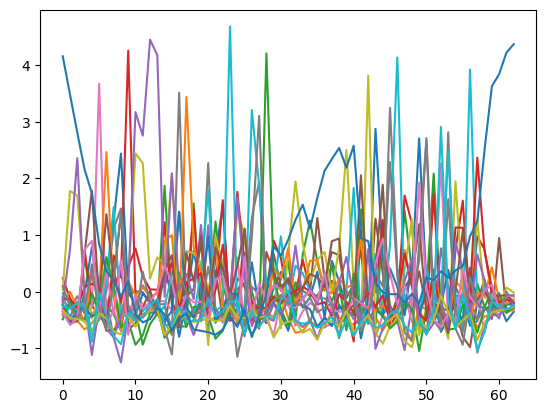

In [33]:
plt.plot(fields[0].cpu().detach().numpy());

In [34]:
fields.shape

torch.Size([1, 63, 21])